In [1]:
import numpy as np 
import tensorflow as tf

import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

In [2]:
# Load MNIST data in a format suited for tensorflow.

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
n_hidden = 500
n_z = 20
batchsize = 100

In [4]:
# leaky reLu unit
def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

# standard convolution layer
def conv2d(x, inputFeatures, outputFeatures, name):
    with tf.variable_scope(name):
        w = tf.get_variable("w",[5,5,inputFeatures, outputFeatures], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b = tf.get_variable("b",[outputFeatures], initializer=tf.constant_initializer(0.0))
        conv = tf.nn.conv2d(x, w, strides=[1,2,2,1], padding="SAME") + b
        return conv
    
# fully-conected layer
def dense(x, inputFeatures, outputFeatures, scope=None, with_w=False):
    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [inputFeatures, outputFeatures], tf.float32, tf.random_normal_initializer(stddev=0.02))
        bias = tf.get_variable("bias", [outputFeatures], initializer=tf.constant_initializer(0.0))
        if with_w:
            return tf.matmul(x, matrix) + bias, matrix, bias
        else:
            return tf.matmul(x, matrix) + bias

In [5]:
# encoder
def recognition(input_images, size):
    with tf.variable_scope("recognition"):
        h1 = lrelu(conv2d(input_images, 1, 16, "d_h1")) # 28x28x1 -> 14x14x16
        h2 = lrelu(conv2d(h1, 16, 32, "d_h2")) # 14x14x16 -> 7x7x32
        h2_flat = tf.reshape(h2,[ size, 7*7*32])

        w_mean = dense(h2_flat, 7*7*32, n_z, "w_mean")
        w_stddev = dense(h2_flat, 7*7*32, n_z, "w_stddev")

    return w_mean, w_stddev

In [6]:
images = tf.placeholder(tf.float32, [None, 784])
image_matrix = tf.reshape(images,[-1, 28, 28, 1])
size = tf.shape(image_matrix)[0]
z_mean, z_stddev = recognition(image_matrix, size)
size = 100; 
samples = tf.random_normal([size,n_z],0,1,dtype=tf.float32)
guessed_z = z_mean + (z_stddev * samples)


In [7]:
def conv_transpose(x, outputShape, name):
    with tf.variable_scope(name):
        # h, w, out, in
        w = tf.get_variable("w",[5,5, outputShape[-1], x.get_shape()[-1]], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b = tf.get_variable("b",[outputShape[-1]], initializer=tf.constant_initializer(0.0))
        convt = tf.nn.conv2d_transpose(x, w, output_shape=outputShape, strides=[1,2,2,1])
        return convt


In [8]:
def generation(z):
        with tf.variable_scope("generation"):
            z_develop = dense(z, n_z, 7*7*32, scope='z_matrix')
            z_matrix = tf.nn.relu(tf.reshape(z_develop, [size, 7, 7, 32]))
            h1 = tf.nn.relu(conv_transpose(z_matrix, [size, 14, 14, 16], "g_h1"))
            h2 = conv_transpose(h1, [size, 28, 28, 1], "g_h2")
            h2 = tf.nn.sigmoid(h2)

        return h2

In [9]:
generated_images = generation(guessed_z)
generated_flat = tf.reshape(generated_images, [size, 28*28])


In [10]:
generation_loss = -tf.reduce_sum(images * tf.log(1e-8 + generated_flat) + (1-images) * tf.log(1e-8 + 1 - generated_flat),1)
latent_loss = 0.5 * tf.reduce_sum(tf.square(z_mean) + tf.square(z_stddev) - tf.log(tf.square(z_stddev)) - 1,1)
cost = tf.reduce_mean(generation_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)


In [11]:
# Merge images 
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1]))

    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx / size[1]
        img[j*h:j*h+h, i*w:i*w+w] = image

    return img

In [12]:
# train 
from scipy.misc import imsave as ims
import os

visualization = mnist.train.next_batch(batchsize)[0]
reshaped_vis = visualization.reshape(batchsize,28,28)
ims("base.jpg",merge(reshaped_vis[:64],[8,8]))
saver = tf.train.Saver(max_to_keep=2)
sess= tf.Session()
#with tf.Session() as sess:
sess.run(tf.initialize_all_variables())
for epoch in range(10):
    for idx in range(int(n_samples / batchsize)):
        batch = mnist.train.next_batch(batchsize)[0]
        _, gen_loss, lat_loss = sess.run((optimizer, generation_loss, latent_loss), feed_dict={images: batch})
        # dumb hack to print cost every epoch
        if idx % (n_samples - 3) == 0:
            print "epoch %d: genloss %f latloss %f" % (epoch, np.mean(gen_loss), np.mean(lat_loss))
            saver.save(sess, os.getcwd()+"/train",global_step=epoch)
            generated_test = sess.run(generated_images, feed_dict={images: visualization})
            generated_test = generated_test.reshape(batchsize,28,28)
            ims(""+str(epoch)+".jpg",merge(generated_test[:64],[8,8]))

epoch 0: genloss 543.428345 latloss 107.763580
epoch 1: genloss 160.845398 latloss 12.371805
epoch 2: genloss 94.082581 latloss 22.403114
epoch 3: genloss 85.474388 latloss 23.108919
epoch 4: genloss 86.332214 latloss 24.453379
epoch 5: genloss 81.361122 latloss 23.986946
epoch 6: genloss 79.254089 latloss 23.529854
epoch 7: genloss 78.079163 latloss 24.258537
epoch 8: genloss 78.611244 latloss 24.435110
epoch 9: genloss 79.857239 latloss 24.984966


In [26]:
#multiple gen
sample = mnist.train.next_batch(1)[0]
print sample.size
imgArray = np.reshape(sample,[28,28])

784


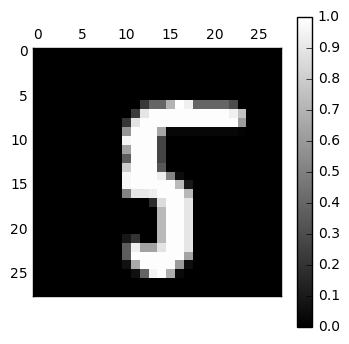

In [27]:
plt.matshow(imgArray, cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.show()

In [28]:
reshapeSample = np.reshape(sample,[1,784])

output = sess.run((generated_images),feed_dict={images: reshapeSample})
print output.shape
output = np.reshape(output,[100,28,28])
print output.shape

(100, 28, 28, 1)
(100, 28, 28)


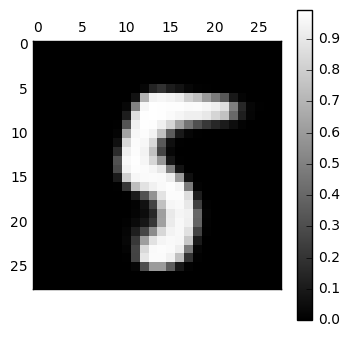

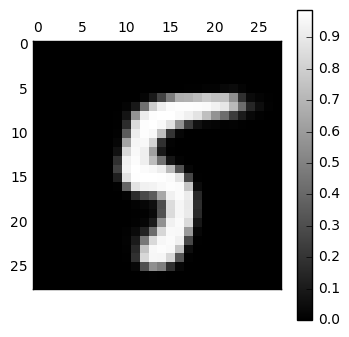

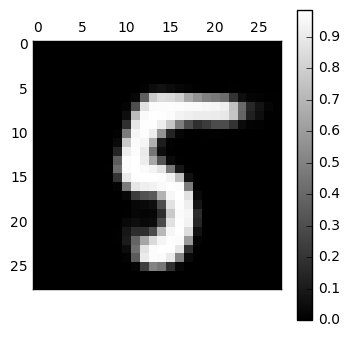

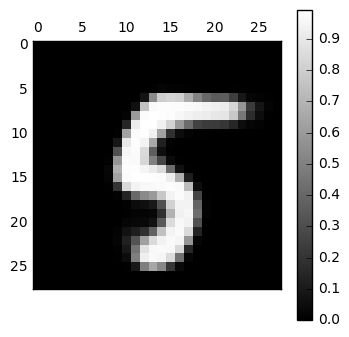

In [29]:
for i in range(4):
    plt.matshow(output[i+5,:], cmap=plt.get_cmap('gray'))
    plt.colorbar()
    plt.show()